In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import *
import datetime
spark = SparkSession.builder.getOrCreate()

In [2]:
spark \
.read \
.option('header',True)\
.option('inferSchema', True)\
.csv(f'/home/jovyan/FAANG_stocks_covid19/faang_stocks_pandemic_data.csv') \
.createOrReplaceTempView('FAANG_stocks')

In [3]:
df = spark.table('FAANG_stocks')
df.toPandas()

,_c0,Date,High,Low,Open,Close,Volume,Adj Close,Name
0,683,2020-01-02,209.789993,206.270004,206.750000,209.779999,12077100.0,209.779999,Facebook
1,684,2020-01-03,210.399994,206.949997,207.210007,208.669998,11188400.0,208.669998,Facebook
2,685,2020-01-06,212.779999,206.520004,206.699997,212.600006,17058900.0,212.600006,Facebook
3,686,2020-01-07,214.580002,211.750000,212.820007,213.059998,14912400.0,213.059998,Facebook
4,687,2020-01-08,216.240005,212.610001,213.000000,215.220001,13475000.0,215.220001,Facebook
...,...,...,...,...,...,...,...,...,...
2835,1246,2022-03-28,2840.050049,2796.229980,2818.010010,2829.110107,1752500.0,2829.110107,Google
2836,1247,2022-03-29,2875.870117,2840.770020,2852.949951,2850.110107,1715900.0,2850.110107,Google
2837,1248,2022-03-30,2854.409912,2832.000000,2849.199951,2838.770020,994200.0,2838.770020,Google
2838,1249,2022-03-31,2842.159912,2780.489990,2841.060059,2781.350098,1876200.0,2781.350098,Google


In [4]:
df.dtypes

[('_c0', 'int'),
 ('Date', 'string'),
 ('High', 'double'),
 ('Low', 'double'),
 ('Open', 'double'),
 ('Close', 'double'),
 ('Volume', 'double'),
 ('Adj Close', 'double'),
 ('Name', 'string')]

In [5]:
df = df\
.withColumn('date', F.col('Date').cast('timestamp'))\
.withColumn('high_price',  F.round(F.col('High'),2))\
.withColumn('low_price', F.round(F.col('Low'),2))\
.withColumn('open_price', F.round(F.col('Open'),2))\
.withColumn('close_price', F.round(F.col('Close'),2))\
.withColumn('stock_name', F.col('Name'))

In [7]:
df.select('stock_name').distinct().show()

+----------+
|stock_name|
+----------+
|    Google|
|     Apple|
|   Netflix|
|    Amazon|
|  Facebook|
+----------+



In [8]:
df = df\
.withColumn('average_price', F.round(((F.col('high_price') + F.col('low_price') + F.col('open_price') + F.col('close_price'))
                              / 4),2).cast('double'))

In [11]:
df.select(
    F.col('stock_name'), 
    F.col('high_price'), 
    F.col('low_price'), 
    F.col('open_price'), 
    F.col('close_price'),
    F.col('average_price'),
    F.col('date')
        )\
.toPandas()

,stock_name,high_price,low_price,open_price,close_price,average_price,date
0,Facebook,209.79,206.27,206.75,209.78,208.15,2020-01-02
1,Facebook,210.40,206.95,207.21,208.67,208.31,2020-01-03
2,Facebook,212.78,206.52,206.70,212.60,209.65,2020-01-06
3,Facebook,214.58,211.75,212.82,213.06,213.05,2020-01-07
4,Facebook,216.24,212.61,213.00,215.22,214.27,2020-01-08
...,...,...,...,...,...,...,...
2835,Google,2840.05,2796.23,2818.01,2829.11,2820.85,2022-03-28
2836,Google,2875.87,2840.77,2852.95,2850.11,2854.93,2022-03-29
2837,Google,2854.41,2832.00,2849.20,2838.77,2843.60,2022-03-30
2838,Google,2842.16,2780.49,2841.06,2781.35,2811.27,2022-03-31


In [16]:
facebook_stocks = df\
.where(F.col('stock_name') == 'Facebook')\
.groupBy(F.date_format(F.col('date'), 'yyyy-MM').alias('date_yyyy_mm'))\
.agg(
    F.avg(F.col('average_price')).alias('avg_stock_price')
        )\
.orderBy(F.col('date_yyyy_mm'), ascending = True)

In [17]:
facebook_stocks.limit(10).toPandas()

,date_yyyy_mm,avg_stock_price
0,2020-01,216.358571
1,2020-02,207.297368
2,2020-03,165.399545
3,2020-04,176.876190
4,2020-05,216.258000
5,2020-06,231.610455
6,2020-07,238.830909
7,2020-08,268.383333
8,2020-09,267.155238
9,2020-10,270.234545


<AxesSubplot:xlabel='date_yyyy_mm'>

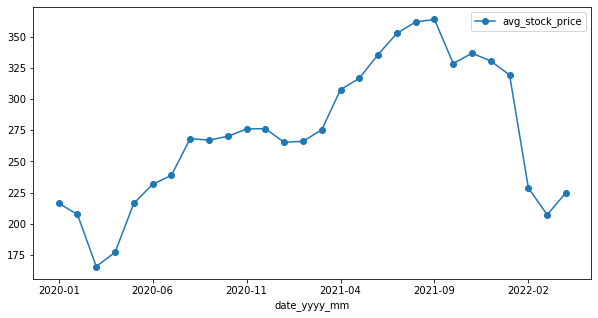

In [32]:
df_facebook = facebook_stocks.toPandas()
df_facebook.plot('date_yyyy_mm','avg_stock_price', figsize=(10,5), marker="o")

In [33]:
amazon_stocks = df\
.where(F.col('stock_name') == 'Amazon')\
.groupBy(F.date_format(F.col('date'), 'yyyy-MM').alias('date_yyyy_mm'))\
.agg(
    F.avg(F.col('average_price')).alias('avg_stock_price')
        )\
.orderBy(F.col('date_yyyy_mm'), ascending = True)

In [34]:
amazon_stocks.limit(10).toPandas()

,date_yyyy_mm,avg_stock_price
0,2020-01,1884.660476
1,2020-02,2067.840526
2,2020-03,1867.752727
3,2020-04,2221.898095
4,2020-05,2392.178500
5,2020-06,2610.725000
6,2020-07,3051.782273
7,2020-08,3245.781429
8,2020-09,3168.060476
9,2020-10,3235.299545


<AxesSubplot:xlabel='date_yyyy_mm'>

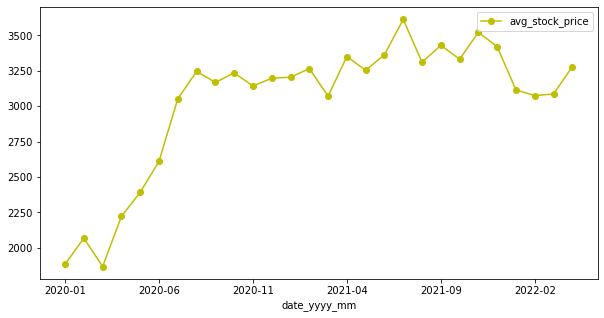

In [35]:
df_amazon = amazon_stocks.toPandas()
df_amazon.plot('date_yyyy_mm','avg_stock_price', figsize=(10,5), marker="o", c="y")

In [36]:
netflix_stocks = df\
.where(F.col('stock_name') == 'Netflix')\
.groupBy(F.date_format(F.col('date'), 'yyyy-MM').alias('date_yyyy_mm'))\
.agg(
    F.avg(F.col('average_price')).alias('avg_stock_price')
        )\
.orderBy(F.col('date_yyyy_mm'), ascending = True)

In [37]:
netflix_stocks.limit(10).toPandas()

,date_yyyy_mm,avg_stock_price
0,2020-01,338.381429
1,2020-02,373.302632
2,2020-03,350.359545
3,2020-04,403.431429
4,2020-05,433.481500
5,2020-06,438.038182
6,2020-07,498.342727
7,2020-08,497.329048
8,2020-09,495.666667
9,2020-10,516.543182


<AxesSubplot:xlabel='date_yyyy_mm'>

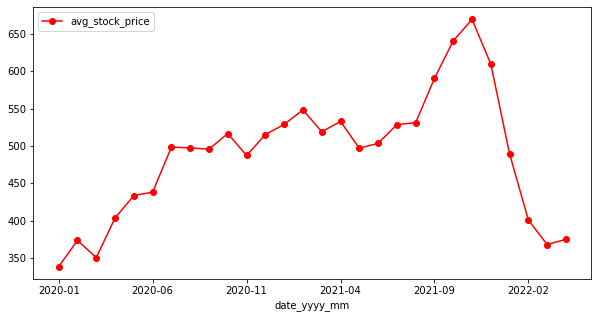

In [38]:
df_netflix = netflix_stocks.toPandas()
df_netflix.plot('date_yyyy_mm','avg_stock_price', figsize=(10,5), marker="o", c="r")

In [39]:
apple_stocks = df\
.where(F.col('stock_name') == 'Apple')\
.groupBy(F.date_format(F.col('date'), 'yyyy-MM').alias('date_yyyy_mm'))\
.agg(
    F.avg(F.col('average_price')).alias('avg_stock_price')
        )\
.orderBy(F.col('date_yyyy_mm'), ascending = True)

In [40]:
apple_stocks.limit(10).toPandas()

,date_yyyy_mm,avg_stock_price
0,2020-01,77.891429
1,2020-02,77.722632
2,2020-03,65.505455
3,2020-04,68.004286
4,2020-05,77.407500
5,2020-06,86.270909
6,2020-07,95.460000
7,2020-08,117.099524
8,2020-09,115.456667
9,2020-10,116.575000


<AxesSubplot:xlabel='date_yyyy_mm'>

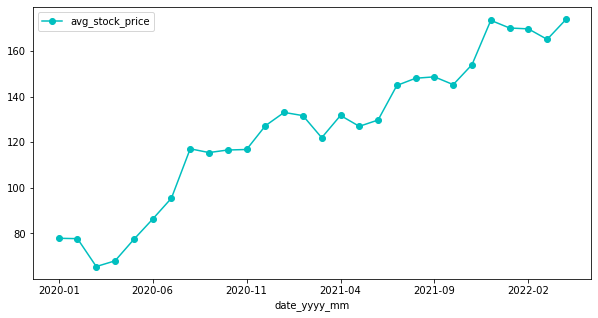

In [41]:
df_apple = apple_stocks.toPandas()
df_apple.plot('date_yyyy_mm','avg_stock_price', figsize=(10,5), marker="o", c="c")

In [42]:
google_stocks = df\
.where(F.col('stock_name') == 'Google')\
.groupBy(F.date_format(F.col('date'), 'yyyy-MM').alias('date_yyyy_mm'))\
.agg(
    F.avg(F.col('average_price')).alias('avg_stock_price')
        )\
.orderBy(F.col('date_yyyy_mm'), ascending = True)

In [43]:
google_stocks.limit(10).toPandas()

,date_yyyy_mm,avg_stock_price
0,2020-01,1434.350952
1,2020-02,1462.422632
2,2020-03,1181.924091
3,2020-04,1230.370952
4,2020-05,1379.725500
5,2020-06,1431.068636
6,2020-07,1512.424091
7,2020-08,1542.898571
8,2020-09,1514.718095
9,2020-10,1542.478636


<AxesSubplot:xlabel='date_yyyy_mm'>

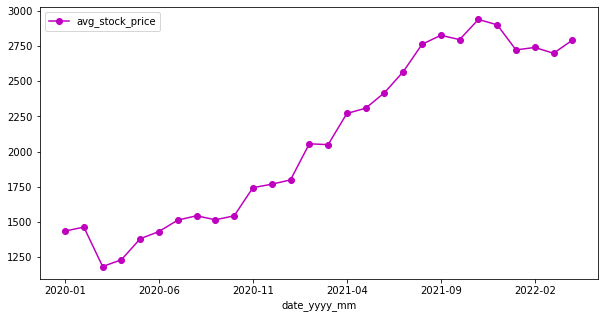

In [44]:
df_google = google_stocks.toPandas()
df_google.plot('date_yyyy_mm','avg_stock_price', figsize=(10,5), marker="o", c="m")